In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


# Loading Data

In [2]:
# load reviews
reviews = pd.read_csv('data/reviews.csv', index_col = 0)

# only 2 columns are needed from reviews, dataset too large, take samples of 10000 rows only
reviews = reviews.sample(10000)[['user_id', 'movie_id', 'rating']]
reviews.dropna(subset = ['rating'], inplace = True)

reviews.sample(5)

,user_id,movie_id,rating
469222,ur49848930,tt9214832,4/10
203024,ur82396246,tt4154796,9/10
4785,ur57423443,tt0448115,1/10
216493,ur106329323,tt4354756,6/10
240547,ur49605005,tt5097410,2/10


In [3]:
# load movies
movies = pd.read_csv('data/movies.csv', index_col = 0)

# select columns with numerical information only
movies = movies[[
    'movie_id', 'genre', 'average_rating', 'metascore', 'critic_count', 'review_count', 'awards'
]]

movies.dropna(subset = ['average_rating', 'metascore'], inplace = True)

movies.sample(5)

,movie_id,genre,average_rating,metascore,critic_count,review_count,awards
4638,tt4257940,['Romance'],5.8,49.0,10 critic,29 user,[]
1582,tt6927492,"['Comedy', 'Drama']",5.1,48.0,18 critic,8 user,['1 nomination.']
2382,tt7349950,"['Drama', 'Fantasy', 'Horror']",6.6,58.0,416 critic,"2,169 user",['5 wins & 18 nominations.']
1616,tt7645122,"['Comedy', 'Drama', 'Romance']",6.6,65.0,43 critic,79 user,['2 wins.']
182,tt8342680,"['Action', 'Drama', 'Thriller']",5.6,55.0,25 critic,7 user,['1 win.']


## Data Processing / Cleaning

In [4]:
# function to calculate award won by movie
def get_award_won (award_string):
    
    # parse awards (string) as array
    awards = literal_eval(award_string)
    awards_won = 0
    
    if len(awards) == 1:
        for label in awards[0].split('&'):
            if label.lower().strip().find("win") != -1:
                awards_won = awards_won + int(re.findall('\d+', label)[0])
                
    elif len(awards) > 1:
        if awards[0].lower().find("won") != -1:
            awards_won = awards_won + int(re.findall('\d+', awards[0])[0])
            
        for label in awards[1].split('&'):
            if label.lower().strip().find("win") != -1:
                awards_won = awards_won + int(re.findall('\d+', label)[0])
    
    return awards_won



In [5]:
# reviews: eval rating into numerical score
reviews['rating'] = reviews['rating'].apply( lambda x: eval(str(x)))

# movies: extract critic count and review count from string
movies['critic_count'] = movies['critic_count'].str.replace(',', '').str.extract('(\d+)').fillna("0").astype(int)
movies['review_count'] = movies['review_count'].str.replace(',', '').str.extract('(\d+)').fillna("0").astype(int)

# movies: calculate award won
movies['awards_won'] = movies['awards'].apply(get_award_won)

# verify calculated values
for i, r in movies[movies['awards'] != '[]'][['awards', 'awards_won']].sample(5).iterrows():
    print(r['awards'], r['awards_won'])

# drop original awards column
movies.drop(['awards'], axis = 1, inplace = True)

['2 nominations.'] 0
['3 wins & 12 nominations.'] 3
['2 wins.'] 2
['1 win & 4 nominations.'] 1
['Nominated for\n            2\n            Oscars.', 'Another\n        19 wins & 42 nominations.'] 19


## Summarize user's review activities

In [6]:
# group and aggregate reviews dataset to produce users dataset
users = reviews.groupby('user_id') \
    .agg({'user_id':'size', 'rating':'mean'}) \
    .rename(columns={'user_id':'review_count', 'rating':'rating_average'}) \
    .reset_index()

users.sample(5)

,user_id,review_count,rating_average
1504,ur114710884,1,0.5
4458,ur44388148,1,0.9
6988,ur74258105,1,0.6
8751,ur99058053,1,0.9
6705,ur70286516,1,0.7


## Merge reviews and movies datasets

In [7]:
# merge movies related information to reviews dataset
movie_reviews = pd.merge(reviews, movies, on = 'movie_id', how = 'inner')
movie_reviews.sample(5)

,user_id,movie_id,rating,genre,average_rating,metascore,critic_count,review_count,awards_won
246,ur67595110,tt4154796,0.1,"['Action', 'Adventure', 'Drama']",8.4,78.0,551,8784,65
3079,ur77760482,tt3794354,0.9,"['Action', 'Adventure', 'Comedy']",6.6,47.0,242,974,0
3432,ur18066467,tt5033998,0.2,"['Action', 'Adventure', 'Comedy']",4.7,52.0,174,1070,1
5675,ur119518323,tt1552211,0.3,"['Action', 'Crime', 'Thriller']",3.6,15.0,55,294,0
5525,ur23834638,tt5884052,0.6,"['Adventure', 'Comedy', 'Family']",6.6,53.0,279,894,0


## Visualize & Find suitable attributes for clustering

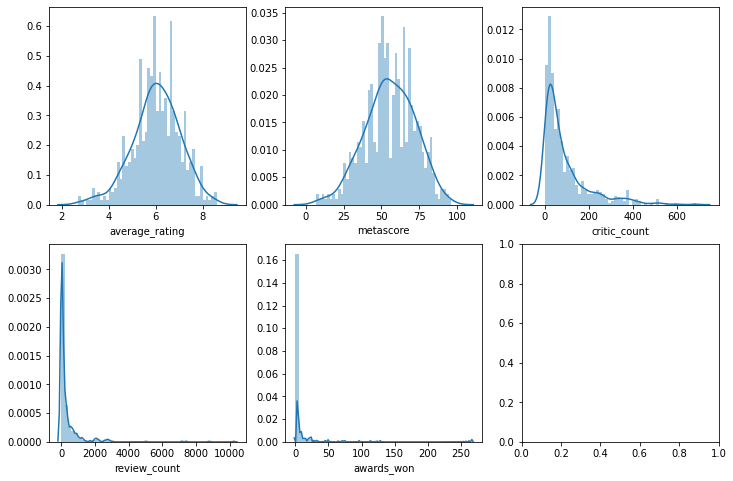

In [8]:
# Movies Dataset

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sns.distplot(movies['average_rating'], ax=axes[0, 0], bins = 50)
sns.distplot(movies['metascore'], ax=axes[0, 1], bins = 50)
sns.distplot(movies['critic_count'], ax=axes[0, 2], bins = 50)
sns.distplot(movies['review_count'], ax=axes[1, 0], bins = 50)
sns.distplot(movies['awards_won'], ax=axes[1, 1], bins = 50)

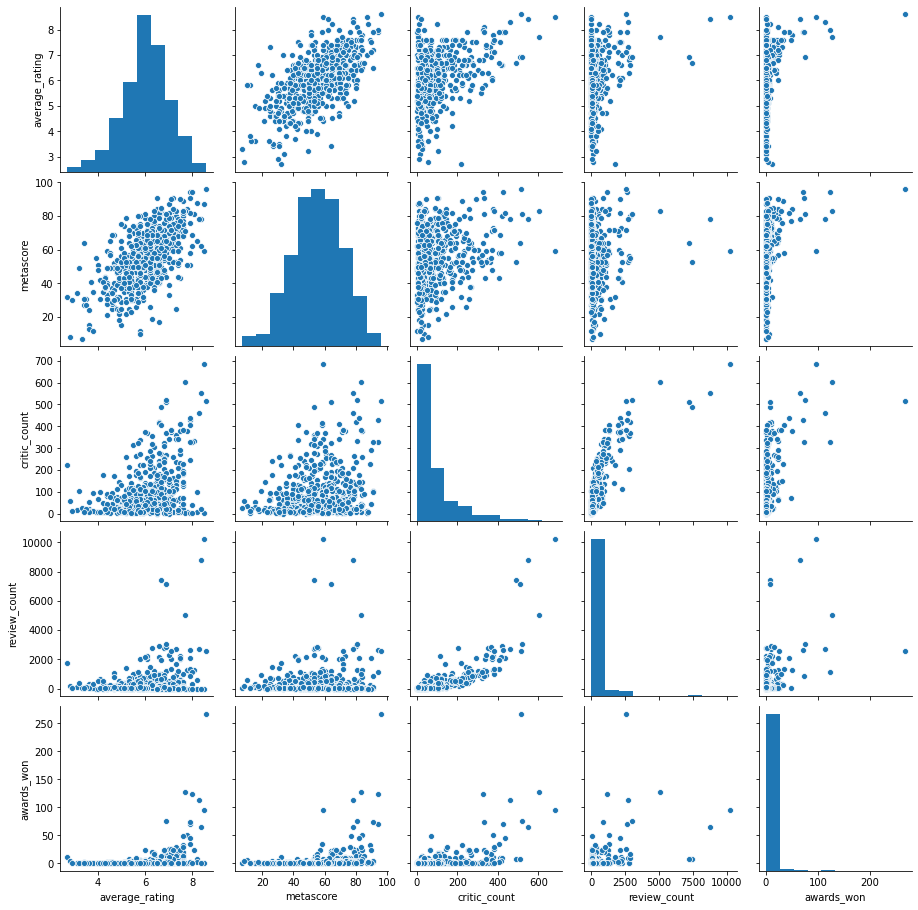

In [9]:
sns.pairplot(movies)

/home/kitlim/py3_kernel/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


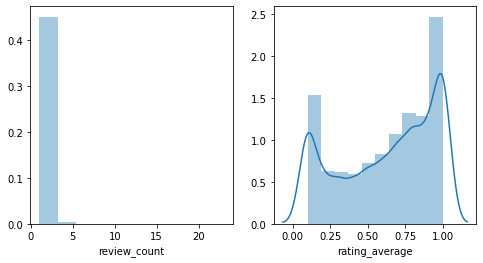

In [10]:
# Users Dataset

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.distplot(users['review_count'], ax=axes[0], bins = 10)
sns.distplot(users['rating_average'], ax=axes[1], bins = 10)

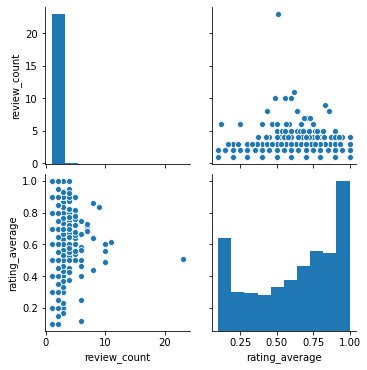

In [11]:
sns.pairplot(users)

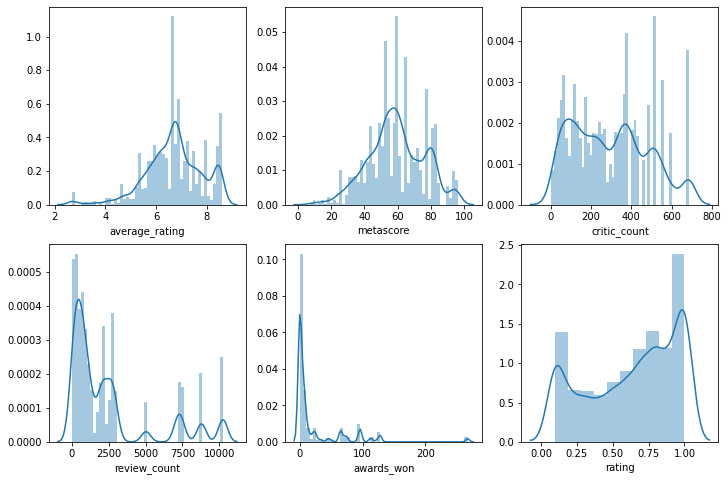

In [12]:
# Movie_reviews Dataset

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sns.distplot(movie_reviews['average_rating'], ax=axes[0, 0], bins = 50)
sns.distplot(movie_reviews['metascore'], ax=axes[0, 1], bins = 50)
sns.distplot(movie_reviews['critic_count'], ax=axes[0, 2], bins = 50)
sns.distplot(movie_reviews['review_count'], ax=axes[1, 0], bins = 50)
sns.distplot(movie_reviews['awards_won'], ax=axes[1, 1], bins = 50)
sns.distplot(movie_reviews['rating'], ax=axes[1, 2], bins = 10)

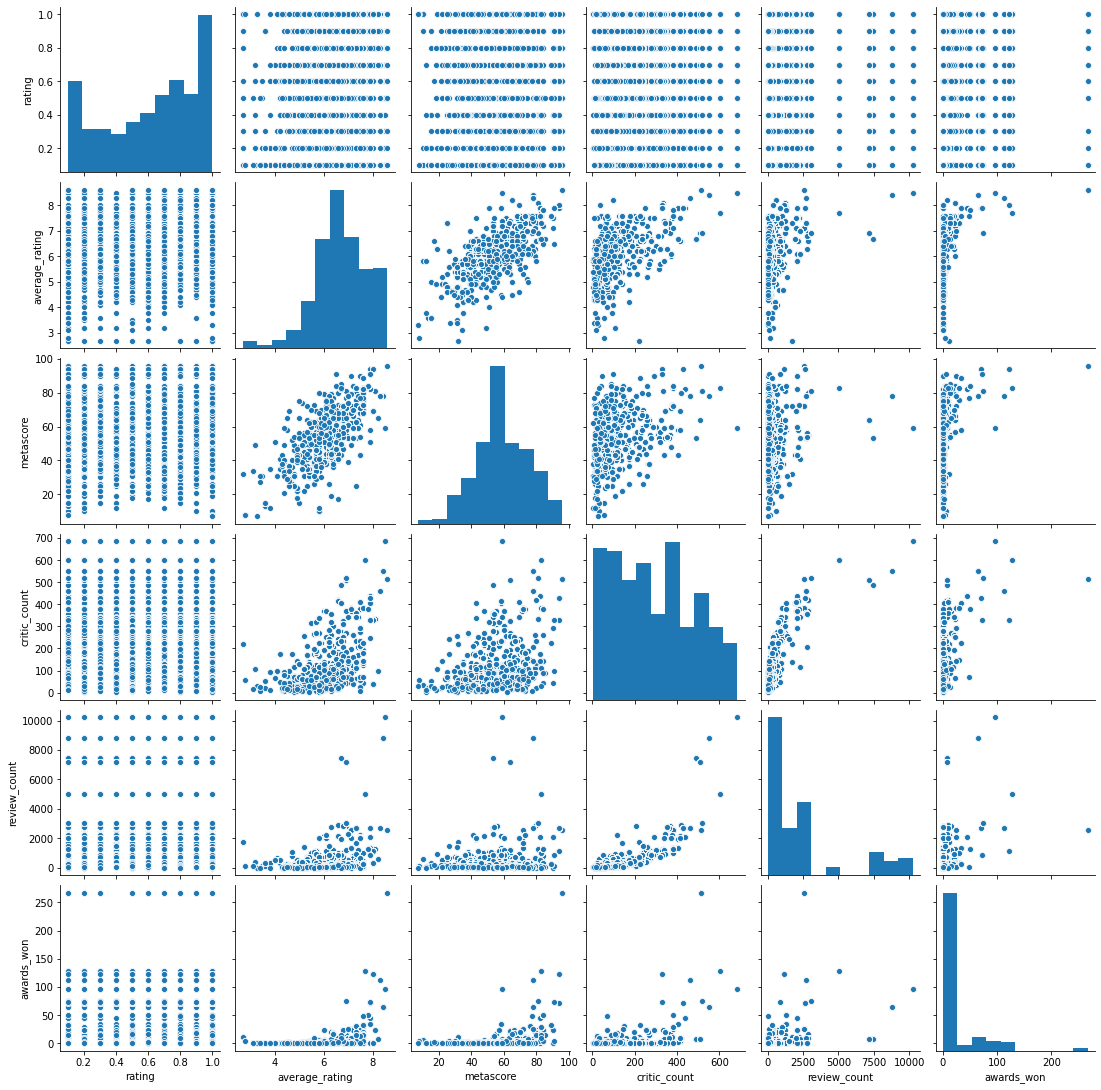

In [13]:
sns.pairplot(movie_reviews)

# Desity Based Clustering

In [14]:
# generic fuction to construct density based clustering model based on input parameters

def dbscan_cluster(df, columns, eps, min_samples):
    
    # normalize 
    standard_scaler = StandardScaler()
    x_scaled = standard_scaler.fit_transform(df[columns].values)
    df = pd.DataFrame(x_scaled)

    data = df.values.astype('float32', copy = False)
    
    # model
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    y = dbscan.fit_predict(data)
    
    cluster_labels = np.unique(y)
    
    # output clustering results
    data_outliers = df[dbscan.labels_ == -1]
    data_clusters = df[dbscan.labels_ != -1]
    colors = dbscan.labels_

    colors_clusters = colors[colors != -1]
    colors_outliers = 'white'

    clusters = Counter(dbscan.labels_)

    print('Cluster Labels & Count: ', clusters)
    print('Outliers Samples:\n', data_outliers.sample(5))

    # visualize in scatter plot
    fig = plt.figure()
    ax = fig.add_axes([.1, .1, 1, 1])
    
    # color plots are data with cluster assigned
    ax.scatter(
        data_clusters[0], data_clusters[1], 
        c = colors_clusters, edgecolor = 'grey', s = 50, alpha = 0.25
    )
    
    # hite plots with black edge are outliers
    ax.scatter(
        data_outliers[0], data_outliers[1], 
        c = colors_outliers, edgecolor = 'black', s = 50, alpha = 0.75
    )

    ax.set_xlabel(columns[0] + ' (normalized)', family = 'DejaVu Sans', fontsize = 9)
    ax.set_ylabel(columns[1] + ' (normalized)', family = 'DejaVu Sans', fontsize = 9)

    plt.title(columns[1] + ' vs ' + columns[0])

    plt.grid(which = 'major', color = '#CCCCCC', alpha = 0.25)


## Try clustering using different attributes in different datasets

Cluster Labels & Count:  Counter({0: 561, 1: 20, -1: 8})
Outliers Samples:
              0         1
24    7.859941  3.909099
6     8.150283  3.721509
5     2.827350  1.057733
322  11.393585  5.559890
36    1.565746  0.448066


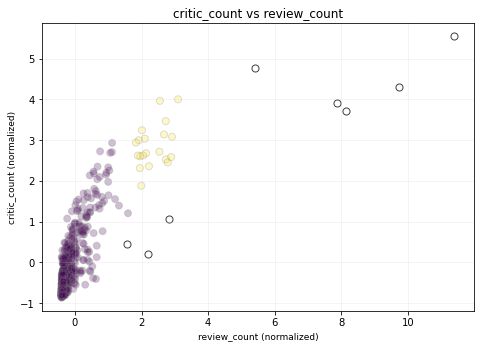

In [15]:
# Movies Dataset: critic_count vs review_count

dbscan_cluster(movies, ['review_count', 'critic_count'], 0.65, 5)

Cluster Labels & Count:  Counter({0: 444, -1: 127, 2: 11, 1: 7})
Outliers Samples:
             0         1
209  1.959172  2.355877
454 -1.421353 -1.324627
348  0.964900 -1.385969
197  1.660890  1.681118
88  -0.824790 -2.060728


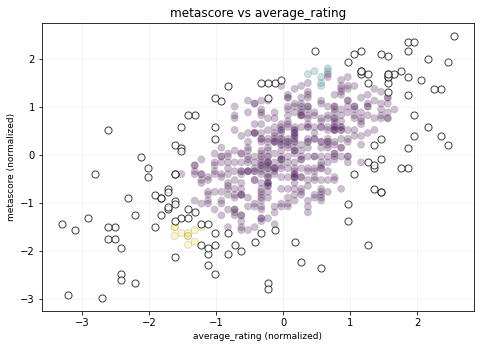

In [16]:
# Movies Dataset: metascore vs average_rating

dbscan_cluster(movies, ['average_rating', 'metascore'], 0.25, 10)

Cluster Labels & Count:  Counter({1: 504, -1: 68, 0: 12, 2: 5})
Outliers Samples:
             0         1
194  1.859744  2.497716
473  2.158026 -0.123034
298 -0.725363  0.181705
154  1.859744  4.082355
562 -2.813334 -0.244929


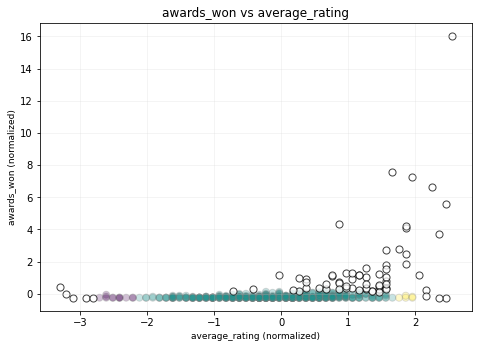

In [17]:
# Movies Dataset: awards_won vs average_rating

dbscan_cluster(movies, ['average_rating', 'awards_won'], 0.15, 5)

Cluster Labels & Count:  Counter({0: 509, -1: 69, 2: 6, 1: 5})
Outliers Samples:
             0         1
363  2.171851  4.204250
425  1.313067  2.741506
462  2.110510 -0.244929
451 -2.367437 -0.123034
154  2.355877  4.082355


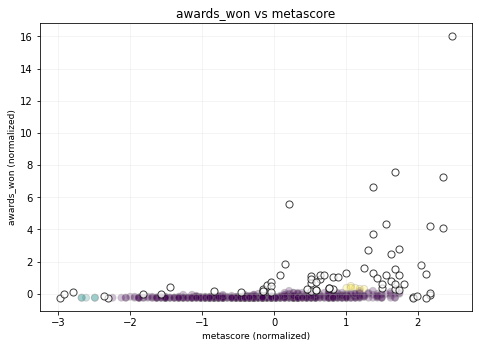

In [18]:
# Movies Dataset: awards_won vs metascore

dbscan_cluster(movies, ['metascore', 'awards_won'], 0.15, 5)

Cluster Labels & Count:  Counter({1: 1918, 6: 1201, 3: 955, 0: 946, 7: 736, 2: 572, 5: 527, 9: 490, 4: 476, 11: 431, 8: 389, 12: 83, -1: 42, 10: 38, 13: 10})
Outliers Samples:
               0         1
3101  10.409618  0.263292
1938   5.110927  1.158158
4580  12.175849  0.727503
560    8.643388 -0.721060
258    5.110927  1.001556


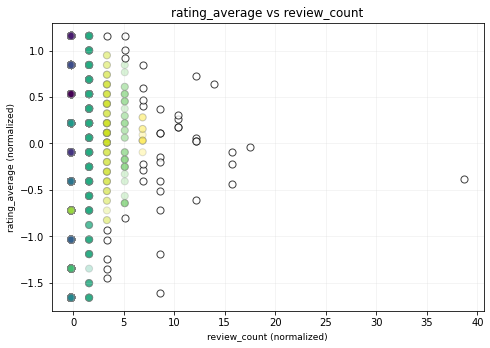

In [19]:
# Users Dataset: rating_average vs review_count

dbscan_cluster(users, ['review_count', 'rating_average'], 0.25, 10)

Cluster Labels & Count:  Counter({1: 1291, 0: 748, 3: 740, 4: 642, 6: 599, 2: 469, 5: 414, 9: 341, 8: 339, 7: 305, -1: 87, 10: 46, 11: 26, 12: 18})
Outliers Samples:
              0         1
3349 -1.381321  1.848749
5828 -1.381321 -2.823394
2932 -0.742630  2.088346
739  -1.381321 -2.404099
2927 -1.061975  2.088346


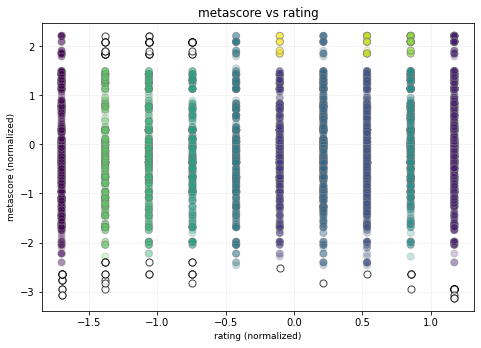

In [20]:
# Movie_reviews Dataset: metascore vs rating

dbscan_cluster(movie_reviews, ['rating', 'metascore'], 0.3, 15)

Cluster Labels & Count:  Counter({1: 1285, 3: 758, 0: 742, 4: 638, 6: 638, 2: 477, 5: 402, 8: 343, 9: 339, 7: 308, -1: 117, 10: 18})
Outliers Samples:
              0         1
907   0.534752 -3.640327
5668  0.854098 -2.823529
912  -1.381321 -3.640327
1066 -1.381321  1.623479
4442  1.173444 -2.642019


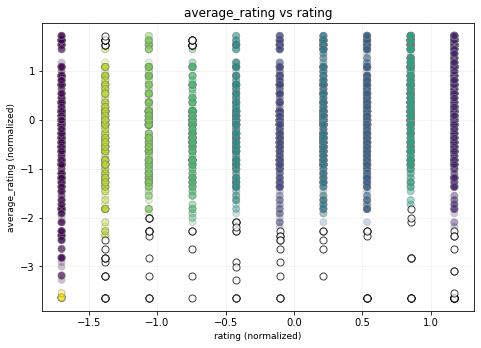

In [21]:
# Movie_reviews Dataset: average_rating vs rating

dbscan_cluster(movie_reviews, ['rating', 'average_rating'], 0.3, 15)